<a href="https://colab.research.google.com/github/Heity94/TWSM_Lab/blob/main/Project/Notebooks/PH_SentenceTransfomer_NounPhrases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Declare whether you are on Colab or local
colab = True

In [2]:
if colab==True:
  
  #Mount drive
  from google.colab import drive
  drive.mount('/content/drive')


  #install required packages
  #!pip install duckdb -q
  !pip install -U sentence-transformers -q

Mounted at /content/drive
     |████████████████████████████████| 85 kB 3.1 MB/s 
     |████████████████████████████████| 4.4 MB 23.0 MB/s 
     |████████████████████████████████| 1.2 MB 54.9 MB/s 
     |████████████████████████████████| 101 kB 15.1 MB/s 
     |████████████████████████████████| 596 kB 71.2 MB/s 
     |████████████████████████████████| 6.6 MB 23.8 MB/s 


In [3]:
#set path to data in Google Drive
data_path = "/content/drive/MyDrive/2022_Analytics Lab Student Projects/Data/All Topics"
data_path_group = data_path[:-10]+"Topic 1/Data_Team1/" # create new data path to access files created by Team1


In [4]:
# Import sentence_transformers 
from sentence_transformers import SentenceTransformer, util
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator, BinaryClassificationEvaluator, TripletEvaluator, LabelAccuracyEvaluator

In [5]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
#import duckdb
#import sqlalchemy
#%load_ext sql

### Load data

#### Noun phrases

In [6]:
entities_train = pd.read_csv(data_path_group+"SynDet/SynDet_entities_train.csv", index_col=0)

In [7]:
# Filter for one article (188)
entities_sample = entities_train.loc[entities_train["article_id"]==188]
entities_sample.shape

(3227, 5)

In [8]:
entities_sample.head(10)

,article_id,sentence_id,ent_id,noun_phrases,true_ent_id
0,188,188_3753_3772,videotex,which,0
1,188,188_3753_3772,videotex,we,0
2,188,188_3753_3772,videotex,an information,0
3,188,188_3753_3772,videotex,communication resource,0
4,188,188_3753_3772,videotex,the Minitel system,0
5,188,188_3828_3848,competitive advantage,It,0
6,188,188_3828_3848,competitive advantage,any rm,0
7,188,188_3828_3848,competitive advantage,the eld,0
8,188,188_3828_3848,competitive advantage,so competitive advantages,0
9,188,188_3848_3883,government,This,0


#### Ontology (entities + synonyms)

In [9]:
ontology_train = pd.read_csv(data_path_group+"SynDet/SynDet_ontology_train.csv", index_col=0)

In [10]:
# Check number of synonyms per entity_id
ent_sy_group = ontology_train.groupby("entity_id")[["synonym"]].nunique().sort_values(by="synonym", ascending=False)

In [11]:
# Downsample entities with more than 100 synonyms to a 100 synoyms (but always include "main entity_id" in subsample)
#idx = ent_sy_group[ent_sy_group["synonym"]>100].index.tolist()
#
#dfs = []
#for entity in idx:
#  t1 = ontology_train[(ontology_train.entity_id==entity)&(ontology_train.synonym==entity)]
#  t2 = ontology_train[(ontology_train.entity_id==entity)&(ontology_train.synonym!=entity)].sample(99)
#  dfs.append(pd.concat([t1,t2]))
#dfs.append(ontology_train.loc[~ontology_train["entity_id"].isin(idx)]) # Append dataframe for all entities with less then 100 synonyms to list

# Combine all dataframes 
#ontology_train_ds = pd.concat(dfs).reset_index(drop=True)

In [12]:
#Show synonyms in ontology which appear in more than 1 entity
ontology_train[ontology_train.synonym.duplicated(keep=False)].sort_values(by="synonym")

,entity_id,category,label,synonym
18175,Chief Information Officer,domain specific entity,TOPIC,CIO
64784,individual participant,study object,PARTICIPANTS,CIO
3766,Pearson's Chi square test,methodological entity,ANALYSIS_METHOD,Chi2 test for independence
3486,Pearson's chi squared test of independence bet...,methodological entity,ANALYSIS_METHOD,Chi2 test for independence
3763,Pearson's Chi square test,methodological entity,ANALYSIS_METHOD,Chi2 test for independences
...,...,...,...,...
17916,electronic procurement,domain specific entity,TECHNOLOGY,web procurements
38276,website,domain specific entity,TECHNOLOGY,web sites
38875,web application,domain specific entity,TECHNOLOGY,web sites
3452,chi squared test,methodological entity,ANALYSIS_METHOD,χ 2S


In [13]:
#List of unique entities from ontology with synonyms without downsampling (apparently there are some duplicates in there?!)
#entities_syn_unique_ds = ontology_syn_ds.synonym.unique().tolist()
ontology_train_ds_unique = ontology_train.drop_duplicates(subset="synonym")

#### Synoynms Dataset

In [14]:
ontology_train_synonms = pd.read_csv(data_path_group+"SynDet/Synonym_Dataset/SynDet_ontology_train_syn.csv", index_col=0)

In [15]:
ontology_train_synonms.head(3)

,entity_id,category,label,synonym,is_synonym
235036,individual participant,study object,PARTICIPANTS,usable and information agent,1
189726,individual participant,study object,PARTICIPANTS,professional and senior research executives,1
291037,individual participant,study object,PARTICIPANTS,business and IS IS informant,1


#### Triplets Dataset

In [16]:
ontology_train_trip = pd.read_csv(data_path_group+"SynDet/Triplets_Dataset/SynDet_ontology_train_triplets.csv", index_col=0)

In [17]:
ontology_train_trip.head(3)

,entity_id,positive_example,negative_example
0,electronic health record,online medical records,postal banking
1,archival research,government data sources analysis,action design research
2,communication service infrastructure,digital enabled communication computers,model driven development


### Load model

In [18]:
# Load a pre-trained model
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

### Create similarity functions

Within the sentence tansformer package there are different functions to compute cosine similarity., after testing the performance of the different functions we chose `util.semantic_search`

In [19]:
# create function based on semantic_search
def sem_search_sent_ent(model, sentences, entities, top_k = 1):


  #Compute embeddings
  embeddings_sentences = model.encode(sentences.noun_phrases.to_list(), convert_to_tensor=True, show_progress_bar=True)
  embeddings_entities = model.encode(entities.synonym.to_list(), convert_to_tensor=True, show_progress_bar=True)

  #Compute cosine-similarities for each sentence with all entities and return top k per sentence (list of list of dictonaries)
  cosine_scores = util.semantic_search(embeddings_sentences, embeddings_entities, top_k=top_k) #returns [[{'corpus_id': 483, 'score': 0.483295202255249}],...]

  #loop over results from semantic_search and create dataframe with sentence id and store in list
  dfs = []
  for idx, sim in enumerate(cosine_scores):
    test = pd.DataFrame(sim)
    test["sentence_id"] = sentences.iloc[idx,1]
    test["noun_phrase_txt"] = sentences.iloc[idx,3]
    test = test.rename(columns={"corpus_id":"entity_id"})
    dfs.append(test)

  # concat all dfs 
  dfs_df = pd.concat(dfs)
  dfs_df = dfs_df[["score", "sentence_id", "entity_id", "noun_phrase_txt"]] # reorder columns
  dfs_df[["main_entity_id"]] = dfs_df[["entity_id"]].applymap(lambda x:  entities.iloc[x,0]) # add "main" entity name (since we compare also with synonyms)
  dfs_df[["entity_id"]] = dfs_df[["entity_id"]].applymap(lambda x:  entities.iloc[x,3]) #replace entity_id_idx with real name of entity
  dfs_df = dfs_df.sort_values(by="score", ascending=False, ignore_index=True) # sort by score and reset index

  return dfs_df#, cosine_scores

In [20]:
%%time
sim_scores_sample = sem_search_sent_ent(model, entities_sample, ontology_train_ds_unique, top_k=1)

Batches:   0%|          | 0/101 [00:00<?, ?it/s]

Batches:   0%|          | 0/10626 [00:00<?, ?it/s]

CPU times: user 1min 45s, sys: 4.61 s, total: 1min 49s
Wall time: 1min 53s


### Check performance of similarity scores

In order to determine the range of cosine similarity score we want to include for further processing (so we only show matches which are "fairly" similar to entities from ontology to the user) we will compare the "closest" entity to the "true" label from Rolands & Sebastians DB

In [21]:
# Set max column width to None so we can read the whole sentences
#pd.set_option('display.max_colwidth', None)

In [22]:
sim_scores_sample.head(2)

,score,sentence_id,entity_id,noun_phrase_txt,main_entity_id
0,1.000001,188_4511_4556,IT,it,IS technology
1,1.000001,188_3675_3704,IT,it,IS technology


In [81]:
# Merge sim scores on entities sample to get "true" entity id
sim_scores_sample_mapped = sim_scores_sample.merge(entities_sample
                                              [["sentence_id", "noun_phrases", "true_ent_id"]],
                                               how="left", left_on=["sentence_id", "noun_phrase_txt"], 
                                               right_on=["sentence_id", "noun_phrases"])\
                                               .drop(columns=["noun_phrases"])

In [82]:
# Define columns which should be checked for duplicates
col_dupl = sim_scores_sample_mapped.columns[1:].to_list()

#Drop duplicates
sim_scores_sample_mapped = sim_scores_sample_mapped.drop_duplicates(subset=col_dupl)

In [83]:
#Merge sim scores again on entities sample to get "true" entity id, but this time with the true entity id which was found by Roland
sim_scores_sample_mapped_f =sim_scores_sample_mapped.merge(entities_sample[["sentence_id", "ent_id"]], 
                                                           how="left", left_on=["sentence_id", "main_entity_id"], 
                                                           right_on=["sentence_id", "ent_id"])\
                                                           .rename(columns={"ent_id":"true_ent_id_cmpl_sen"})\
                                                           .drop_duplicates()

In [26]:
# Define function to combine both columns "true_ent_id" & "true_ent_id_cmpl_sen"
def true_ent_label(x):

  if x.true_ent_id!="0":
    return x.true_ent_id
  else:
    return x.true_ent_id_cmpl_sen

In [91]:
# Compare both columns and store correct value  in column true_entity_id
sim_scores_sample_mapped_f["true_entity_id"] = sim_scores_sample_mapped_f.apply(lambda x: true_ent_label(x), 
                                                                                axis=1, result_type="expand")

#Fill all NaN Values with 0 (no match)
sim_scores_sample_mapped_f["true_entity_id"] = sim_scores_sample_mapped_f["true_entity_id"].fillna(0)

#Drop columns "true_ent_id" & "true_ent_id_cmpl_sen"
sim_scores_sample_mapped_f = sim_scores_sample_mapped_f.drop(columns=["true_ent_id", "true_ent_id_cmpl_sen"])

In [92]:
sim_scores_sample_mapped_f.head(3)

,score,sentence_id,entity_id,noun_phrase_txt,main_entity_id,true_entity_id
0,1.000001,188_4511_4556,IT,it,IS technology,0
1,1.000001,188_3675_3704,IT,it,IS technology,0
2,1.000001,188_3828_3848,IT,It,IS technology,0


In [93]:
# Check wheter main_entity based on cosine similarity is identical to "true" main entity label 
sim_scores_sample_mapped_f["correct_match"] = sim_scores_sample_mapped_f.main_entity_id==sim_scores_sample_mapped_f.true_entity_id

In [94]:
sim_scores_sample_mapped_f.head(3)

,score,sentence_id,entity_id,noun_phrase_txt,main_entity_id,true_entity_id,correct_match
0,1.000001,188_4511_4556,IT,it,IS technology,0,False
1,1.000001,188_3675_3704,IT,it,IS technology,0,False
2,1.000001,188_3828_3848,IT,It,IS technology,0,False


In [95]:
# Check results for one sample sentence
sim_scores_sample_mapped_f[(sim_scores_sample_mapped_f.sentence_id=="188_5984_6028")].sort_values(by="score", ascending=False)#&(sim_scores_sample_mapped.score<1.)]

,score,sentence_id,entity_id,noun_phrase_txt,main_entity_id,true_entity_id,correct_match
111,1.000000,188_5984_6028,information infrastructure,information infrastructure,information technology infrastructure,information technology infrastructure,True
337,0.975544,188_5984_6028,private sector,the private sector,private sector,private sector,True
839,0.963922,188_5984_6028,information superhighway,an information superhighway,information superhighway,information superhighway,True
2350,0.855710,188_5984_6028,public sector institutions,the public institutions,government,0,False
2452,0.834706,188_5984_6028,applications project,application,IT project,0,False
2739,0.810322,188_5984_6028,IS development,the development,systems development,0,False
3591,0.752547,188_5984_6028,information service development,service development,information services development,0,False
3593,0.752482,188_5984_6028,information and communications technologies in...,innovative communications,digital innovation,0,False
4028,0.683284,188_5984_6028,receiver operating characteristics,hardware receivers,ROC curve,0,False
4346,0.597921,188_5984_6028,wireless technologies,transmitters,mobile system,0,False


We can see that our algorithm did indeed match 3 tags correctly. We could now use the `correct_match` column to calculate some statistics on how many entities the transfomer did correctly classify (and we will do it below). However, the example above also shows that there are some entities which our algorithm classifies as very similar (e.g. the public institutions) which was not tagged in the original database. This means that the scores which we will calculate below do not reflect the true "accuracy" of our algorithm, since the original mapping of sentences is not perfect!
But we also have to note that our procedure to determine wheter the match was correct also has issues if our algorithm did not correctly predict the main entity (in the example above the sentence was also tagged as hardware, but since our algorithm matched "hardware receivers" incorrectly to "ROC curve", this faulty match does not appear in our dataframe!

In [133]:
# Create bins of similarity score to check the number of correct matches compared to the labels of the database
grouped_df = sim_scores_sample_mapped_f.groupby(pd.cut(sim_scores_sample_mapped_f.score, np.arange(0.,1.1,0.1)))[["correct_match"]]
corr_match_bins = np.round(grouped_df.sum()/grouped_df.count(),2).rename(columns={"correct_match":"pct_correct_in_bin"})
corr_match_bins["no_correct"]= grouped_df.sum()
corr_match_bins["total"]= grouped_df.count()
corr_match_bins = corr_match_bins[["total", "no_correct", "pct_correct_in_bin"]]
corr_match_bins = corr_match_bins.iloc[::-1] #reverse order

In [134]:
corr_match_bins

,total,no_correct,pct_correct_in_bin
score,,,
"(0.9, 1.0]",127,101,0.80
"(0.8, 0.9]",281,94,0.33
"(0.7, 0.8]",264,46,0.17
"(0.6, 0.7]",217,18,0.08
"(0.5, 0.6]",358,4,0.01
"(0.4, 0.5]",252,7,0.03
"(0.3, 0.4]",25,0,0.00
"(0.2, 0.3]",0,0,NaN
"(0.1, 0.2]",0,0,NaN


Lets visualize it in a pareto style plot

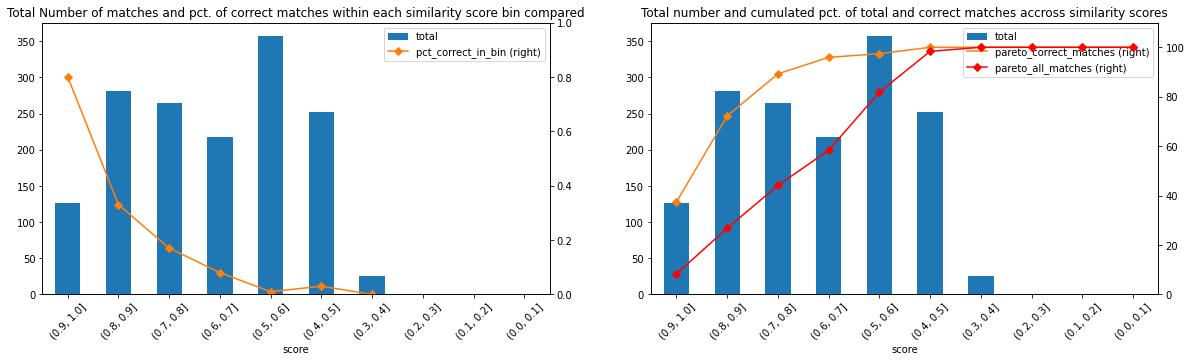

In [167]:
#corr_match_bins = corr_match_bins.iloc[::-1]
corr_match_bins['pareto_correct_matches'] = 100 *corr_match_bins.no_correct.cumsum() / corr_match_bins.no_correct.sum()
corr_match_bins['pareto_all_matches'] = 100 *corr_match_bins.total.cumsum() / corr_match_bins.total.sum()
fig, axes = plt.subplots(1,2, figsize=(20,5))


#First plot
ax01 = corr_match_bins.plot(use_index=True, y='total',  kind='bar', ax=axes[0])
ax02 = corr_match_bins.plot(use_index=True, y='pct_correct_in_bin', marker='D', color="C1", kind='line', ax=axes[0], secondary_y=True)
#ax1.invert_xaxis()
for tick in ax01.get_xticklabels():
    tick.set_rotation(45)
#ax2.invert_xaxis()
ax02.set_ylim([0,1]);
axes[0].set_title("Total Number of matches and pct. of correct matches within each similarity score bin compared");


# First plot
ax1 = corr_match_bins.plot(use_index=True, y='total',  kind='bar', ax=axes[1])
ax2 = corr_match_bins.plot(use_index=True, y='pareto_correct_matches', marker='D', color="C1", kind='line', ax=axes[1], secondary_y=True)
ax4 = corr_match_bins.plot(use_index=True, y='pareto_all_matches', marker='D', color="red", kind='line', ax=axes[1], secondary_y=True)
axes[1].set_title("Total number and cumulated pct. of total and correct matches accross similarity scores");
#ax1.invert_xaxis()
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)
#ax2.invert_xaxis()
ax2.set_ylim([0,110]);

In [34]:
# Lets see how many noun phrases a user would have to look depending on the range we choose
for i in np.arange(0.1,1.,0.1):
  print("Number of phrases a user would need to check if we choose a similarity score range: (",\
        np.round(i,1),",1]:", \
        sim_scores_sample_mapped_f.loc[\
                                     (sim_scores_sample_mapped_f["score"]>=i)&\
                                     (sim_scores_sample_mapped_f["score"]<=0.99)].shape[0])

Number of phrases a user would need to check if we choose a similarity score range: ( 0.1 ,1]: 1502
Number of phrases a user would need to check if we choose a similarity score range: ( 0.2 ,1]: 1502
Number of phrases a user would need to check if we choose a similarity score range: ( 0.3 ,1]: 1502
Number of phrases a user would need to check if we choose a similarity score range: ( 0.4 ,1]: 1477
Number of phrases a user would need to check if we choose a similarity score range: ( 0.5 ,1]: 1225
Number of phrases a user would need to check if we choose a similarity score range: ( 0.6 ,1]: 867
Number of phrases a user would need to check if we choose a similarity score range: ( 0.7 ,1]: 650
Number of phrases a user would need to check if we choose a similarity score range: ( 0.8 ,1]: 386
Number of phrases a user would need to check if we choose a similarity score range: ( 0.9 ,1]: 105


We will now manually check some outputs close to the areas around 0.6 cos sim

In [35]:
# Lets have a look at the matches with a similarity score >0.6 to assess wheter there are some synonyms/ entities mentioned 
sim_scores_sample_mapped_f.loc[(sim_scores_sample_mapped_f["score"]>=0.6)&(sim_scores_sample_mapped_f["score"]<=0.7)].sample(10)

,score,sentence_id,entity_id,noun_phrase_txt,main_entity_id,true_entity_id,correct_match
4255,0.637225,188_6343_6375,THEY,we,IS technology,0,False
3963,0.695617,188_11216_11251,information superhighways,Multimedia Information Superhighways,information superhighway,information superhighway,True
4012,0.688526,188_4854_4876,order processing I,order,order-processing information system,0,False
4015,0.688526,188_6964_6999,order processing I,order,order-processing information system,0,False
4213,0.640729,188_10175_10204,Minitel,OFTEL,videotex,0,False
4009,0.690525,188_9681_9755,digital quality,reduced quality,system quality,0,False
4159,0.653066,188_7486_7522,German BTX,BT,videotex,0,False
4277,0.630379,188_10380_10397,information and information information citizen,the UK information,individual participant,0,False
4338,0.601212,188_2074_2102,multi national organization,national efforts,multi national corporation,0,False
4170,0.649827,188_6046_6080,demand side economies of scale,demand,network effect,0,False


## Evaluate performance of pre-trained model

### Synonym Dataset

In [69]:
ontology_train_synonms.head(1)

,entity_id,category,label,synonym,is_synonym
235036,individual participant,study object,PARTICIPANTS,usable and information agent,1


The `BinaryClassificationEvaluator` evaluates a model based on the similarity of the embeddings by calculating the accuracy of identifying similar and dissimilar sentences. The metrics are the cosine similarity as well as euclidean and Manhattan distance The returned score is the accuracy with a specified metric.

In [70]:
# Instantiate Binary Classification evaluator
test_evaluator_syn = BinaryClassificationEvaluator(ontology_train_synonms.entity_id.to_list(),
                                                   ontology_train_synonms.synonym.to_list(),
                                                   ontology_train_synonms.is_synonym.to_list(),
                                                   show_progress_bar=True,
                                                   write_csv=False
                                                   )

In [ ]:
syn_result = test_evaluator_syn(model)
print(syn_result)

Batches:   0%|          | 0/10624 [00:00<?, ?it/s]

0.8466062860950142


The base score of the pretrained model is 84%

### Triplets Dataset

In [ ]:
ontology_train_trip.head(1)

,entity_id,positive_example,negative_example
0,electronic health record,online medical records,postal banking


The `TripletEvaluator` checks if distance(sentence, positive_example) < distance(sentence, negative_example).

In [ ]:
# Instantiate Tripletevaluator
test_evaluator_trip = TripletEvaluator(ontology_train_trip.entity_id.to_list(),
                                       ontology_train_trip.positive_example.to_list(),
                                       ontology_train_trip.negative_example.to_list(),
                                       main_distance_function=0, #0 (Cosine), 1 (Euclidean) or 2 (Manhattan)
                                       show_progress_bar=True,
                                       write_csv=False
                                       )

In [ ]:
trip_result = test_evaluator_trip(model)
print(trip_result)

Batches:   0%|          | 0/1532 [00:00<?, ?it/s]

Batches:   0%|          | 0/1532 [00:00<?, ?it/s]

Batches:   0%|          | 0/1532 [00:00<?, ?it/s]

0.9661798302872062


The pre trained model is already very accurate when it comes to distinguish differences between a real and fake synonym for a main entity

### Noun phrases and labeled entity

In order to use the sentences/noun phrases as well in training we thought about training a sentence transformer on a classification task (predict correct entity id)

Let's reuse our `sim_scores_sample_mapped_f` dataframe, since we know that this provides a better match between noun phrase and true entity id than the original dataframe

In [ ]:
sim_scores_sample_mapped_f.head(5)

,score,sentence_id,entity_id,noun_phrase_txt,main_entity_id,true_entity_id,correct_match
0,1.000001,188_4511_4556,IT,it,IS technology,0,False
1,1.000001,188_3675_3704,IT,it,IS technology,0,False
2,1.000001,188_3828_3848,IT,It,IS technology,0,False
3,1.000001,188_4876_4905,IT,It,IS technology,0,False
4,1.000001,188_3883_3924,IT,it,IS technology,0,False


In [ ]:
# Create test dataset which only include noun phrases with a true mapped entity 
np_test = sim_scores_sample_mapped_f.loc[sim_scores_sample_mapped_f.true_entity_id!=0,["noun_phrase_txt", "true_entity_id"]]

In [ ]:
# Lets drop duplicates
np_test = np_test.drop_duplicates()

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

In [ ]:
# Ordinal encode true entity label
enc = OrdinalEncoder()
np_test["true_entity_id_enc"] = enc.fit_transform(np_test[["true_entity_id"]])

In [ ]:
# no unique labels
np_test.true_entity_id_enc.nunique()

34

There is a `LabelAccuracyEvaluator` which evaluates a model based on its accuracy on a labeled dataset. But this requires a dataset whcih compares two sentences and the label (e.g. "hypothesis", "comment", "label")
We would want to train a classifier which given the noun phrase learns to correctly label the correct entity id. 
Until now I did not find a solution on how to do it 